# CNN CIFAR

CNN with CIFAR10 dataset using the functional module

## Load Packages

### New Functional module

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

## Load Data

In [2]:
# load train data
train_dataset = torchvision.datasets.CIFAR10(
    root='data/',
    train=True, # Will return the train dataset
    transform=transforms.ToTensor(), #preprocessing 
    download=True
)

# load test data
test_dataset = torchvision.datasets.CIFAR10(
    root='data/',
    train=False, # Will return the test dataset
    transform=transforms.ToTensor(), #preprocessing 
    download=True
)

100.0%Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


In [4]:
train_dataset.data.shape

(50000, 32, 32, 3)

In [5]:
train_dataset.data
# returns a numpy array instead of a tensor

array([[[[ 59,  62,  63],
         [ 43,  46,  45],
         [ 50,  48,  43],
         ...,
         [158, 132, 108],
         [152, 125, 102],
         [148, 124, 103]],

        [[ 16,  20,  20],
         [  0,   0,   0],
         [ 18,   8,   0],
         ...,
         [123,  88,  55],
         [119,  83,  50],
         [122,  87,  57]],

        [[ 25,  24,  21],
         [ 16,   7,   0],
         [ 49,  27,   8],
         ...,
         [118,  84,  50],
         [120,  84,  50],
         [109,  73,  42]],

        ...,

        [[208, 170,  96],
         [201, 153,  34],
         [198, 161,  26],
         ...,
         [160, 133,  70],
         [ 56,  31,   7],
         [ 53,  34,  20]],

        [[180, 139,  96],
         [173, 123,  42],
         [186, 144,  30],
         ...,
         [184, 148,  94],
         [ 97,  62,  34],
         [ 83,  53,  34]],

        [[177, 144, 116],
         [168, 129,  94],
         [179, 142,  87],
         ...,
         [216, 184, 140],
        

In [8]:
type(train_dataset.targets)
# retruns a list insetad of tensor

list

In [12]:
len(set(train_dataset.targets))

10

In [13]:
# get number of classes
K = len(set(train_dataset.targets))
print("Number of classes:", K)

Number of classes: 10


In [15]:
# create train and test data loaders
batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                            batch_size=batch_size,shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                            batch_size=batch_size,shuffle=True)

## Build Model

In [17]:
class CNN(nn.Module):
    def __init__(self,K):
        super(CNN,self).__init__()

        # define conv layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2) 
        # ReLU will be called later as a function
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2)

        # define linear layers
        self.fc1 = nn.Linear(128*3*3,1024)
        self.fc2 = nn.Linear(1024, K)

    def forward(self,x):
        # call relu as a functuon from functional
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 128 * 3 * 3 )
        x = F.dropout(x, p=0.2)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.2)
        x = self.fc2(x) # no relu 
        return x


In [18]:
model = CNN(K)

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cpu


CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
  (fc1): Linear(in_features=1152, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)

In [20]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss() #combines the softmax
optimizer = torch.optim.Adam(model.parameters())

## Train 

In [21]:
def batch_gd(model,criterion,optimizer,train_loader,test_loader,epochs):
    
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for it in range(epochs):
        t0 = datetime.now()
        train_loss = [] # this will store loss per batch
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device) # move data to GPU


            optimizer.zero_grad()

            #forward pass
            outputs = model(inputs)
            loss = criterion(outputs,targets)

            # backward pass and optimize
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item()) # this will loss of the batch

        #get train and test loss
        train_loss=np.mean(train_loss) # The mean can represent the loss for the epoch

        
        test_loss = []
        for inputs,targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device) # move data to GPU
            
            outputs = model(inputs)
            loss = criterion(outputs,targets)
            test_loss.append(loss.item()) # this will loss of the batch

        test_loss=np.mean(test_loss) # The mean can represent the loss for the epoch

        # save losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss
        dt = datetime.now() - t0
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
            Test Loss: {test_loss:.4f},Duration: {dt}')
    return train_losses, test_losses

In [22]:
train_losses, test_losses = batch_gd(
    model, criterion, optimizer, train_loader, test_loader, epochs=15)

Epoch 1/15, Train Loss: 1.6348,             Test Loss: 1.4091,Duration: 0:00:33.965252
Epoch 2/15, Train Loss: 1.3454,             Test Loss: 1.2928,Duration: 0:00:33.744466
Epoch 3/15, Train Loss: 1.2001,             Test Loss: 1.1855,Duration: 0:00:35.023545
Epoch 4/15, Train Loss: 1.0919,             Test Loss: 1.1323,Duration: 0:00:35.662130
Epoch 5/15, Train Loss: 0.9888,             Test Loss: 1.0650,Duration: 0:00:35.167872
Epoch 6/15, Train Loss: 0.9061,             Test Loss: 1.0587,Duration: 0:00:35.441487
Epoch 7/15, Train Loss: 0.8354,             Test Loss: 1.0173,Duration: 0:00:35.704145
Epoch 8/15, Train Loss: 0.7723,             Test Loss: 0.9813,Duration: 0:00:35.727360
Epoch 9/15, Train Loss: 0.7020,             Test Loss: 0.9969,Duration: 0:00:35.621078
Epoch 10/15, Train Loss: 0.6421,             Test Loss: 1.0073,Duration: 0:00:35.390286
Epoch 11/15, Train Loss: 0.5901,             Test Loss: 1.0089,Duration: 0:00:35.432848
Epoch 12/15, Train Loss: 0.5254,         

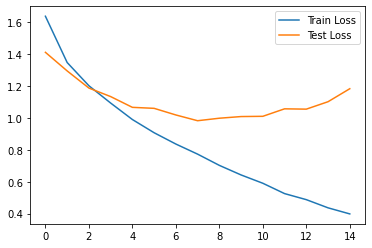

In [23]:
plt.plot(train_losses, label = "Train Loss")
plt.plot(test_losses, label = "Test Loss")
plt.legend();

## Evaluate

In [24]:
# Calculate Train Accuracy
n_correct = 0.
n_total = 0.
for inputs,targets in train_loader:
    inputs, targets = inputs.to(device), targets.to(device) # move data to GPU
    # reshape the input
    #inputs = inputs.view(-1, 784)
    
    # Forward pass
    outputs = model(inputs)

    # Get predictions
    # Since these are logits, get max
    # torch.max() returns both max and argmax
    # retunes the max vale and the corrosponding index. We only want the index
    _, predictions = torch.max(outputs, 1) 

    #update counts 
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

train_acc = n_correct/n_total

# Calculate test accuracy
n_correct = 0.
n_total = 0.
for inputs,targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device) # move data to GPU
    # reshape the input
    #inputs = inputs.view(-1, 784)
    
    # Forward pass
    outputs = model(inputs)

    # Get predictions
    # Since these are logits, get max
    # torch.max() returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    #update counts 
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

test_acc = n_correct/n_total

print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.8804, Test acc: 0.6604
